In [88]:
from src.Recorder.jsonParser import JsonParser
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
%load_ext autoreload
%autoreload 2

font = {'family' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)


LATEX_IMAGES = 'C:/Users/Tobias King/Github/thesis/images/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Load the recorded data

jp = JsonParser("../tmp/20220203-115919")
jp.addJson("../tmp/20220203-192817")
jp.addJson("../tmp/20220204-094455")
jp.addJson("../tmp/20220323-100925")
jp.addJson("../tmp/20220204-094455")


print("num_records: ", jp.numRecords)

num_records:  2401


In [90]:
# Check if timings can be summed up to the whole
for i in range(10):
    rec = jp.getRecord(i)[0]["timing"]

    wholeModel = [x["millis"] for x in rec if x["type"] == 255][0]
    timings = sum([x["millis"] for x in rec if x["type"] not in [1, 255]])
    print(timings, " == ", wholeModel)


64.22731250000001  ==  64.36690625
33.735328125  ==  33.781203125
50.65789062500001  ==  50.693171875
16.909765625000002  ==  16.95475
19.676781249999998  ==  19.713140625
13.037890625  ==  13.405984375000001
21.643406249999998  ==  21.68021875
30.117328125  ==  30.158796875
59.57603125  ==  59.6176875
19.494531249999998  ==  19.537328125


In [91]:
from sklearn.linear_model import LinearRegression


def calcFlops(layerType, config):

    if layerType == "Conv2D":

        [iX, iY, iC] = config["input"]
        [oX, oY, oC] = config["output"]
        [kX, kY, kC] = config["filter"]

        flops = 2* kX * kY * oX * oY * iC * oC
        # Bias
        flops += oX * oY * oC

    if layerType == "Dense":

        input = config["input"]
        output = config["output"]

        flops = 2 * input * output

        #Bias
        flops += output
        

    if layerType == "DepthWiseConv2D":
        [iX, iY, iC] = config["input"]
        [oX, oY, oC] = config["output"]
        [kX, kY, kC] = config["filter"]

    assert not np.isnan(flops)
    assert not np.isinf(flops)

    return flops

## Whole Model

2401
R^2 - Score:  0.9301656733398569
LGR_Latency_Coeffs:  [3.33339446e-05]


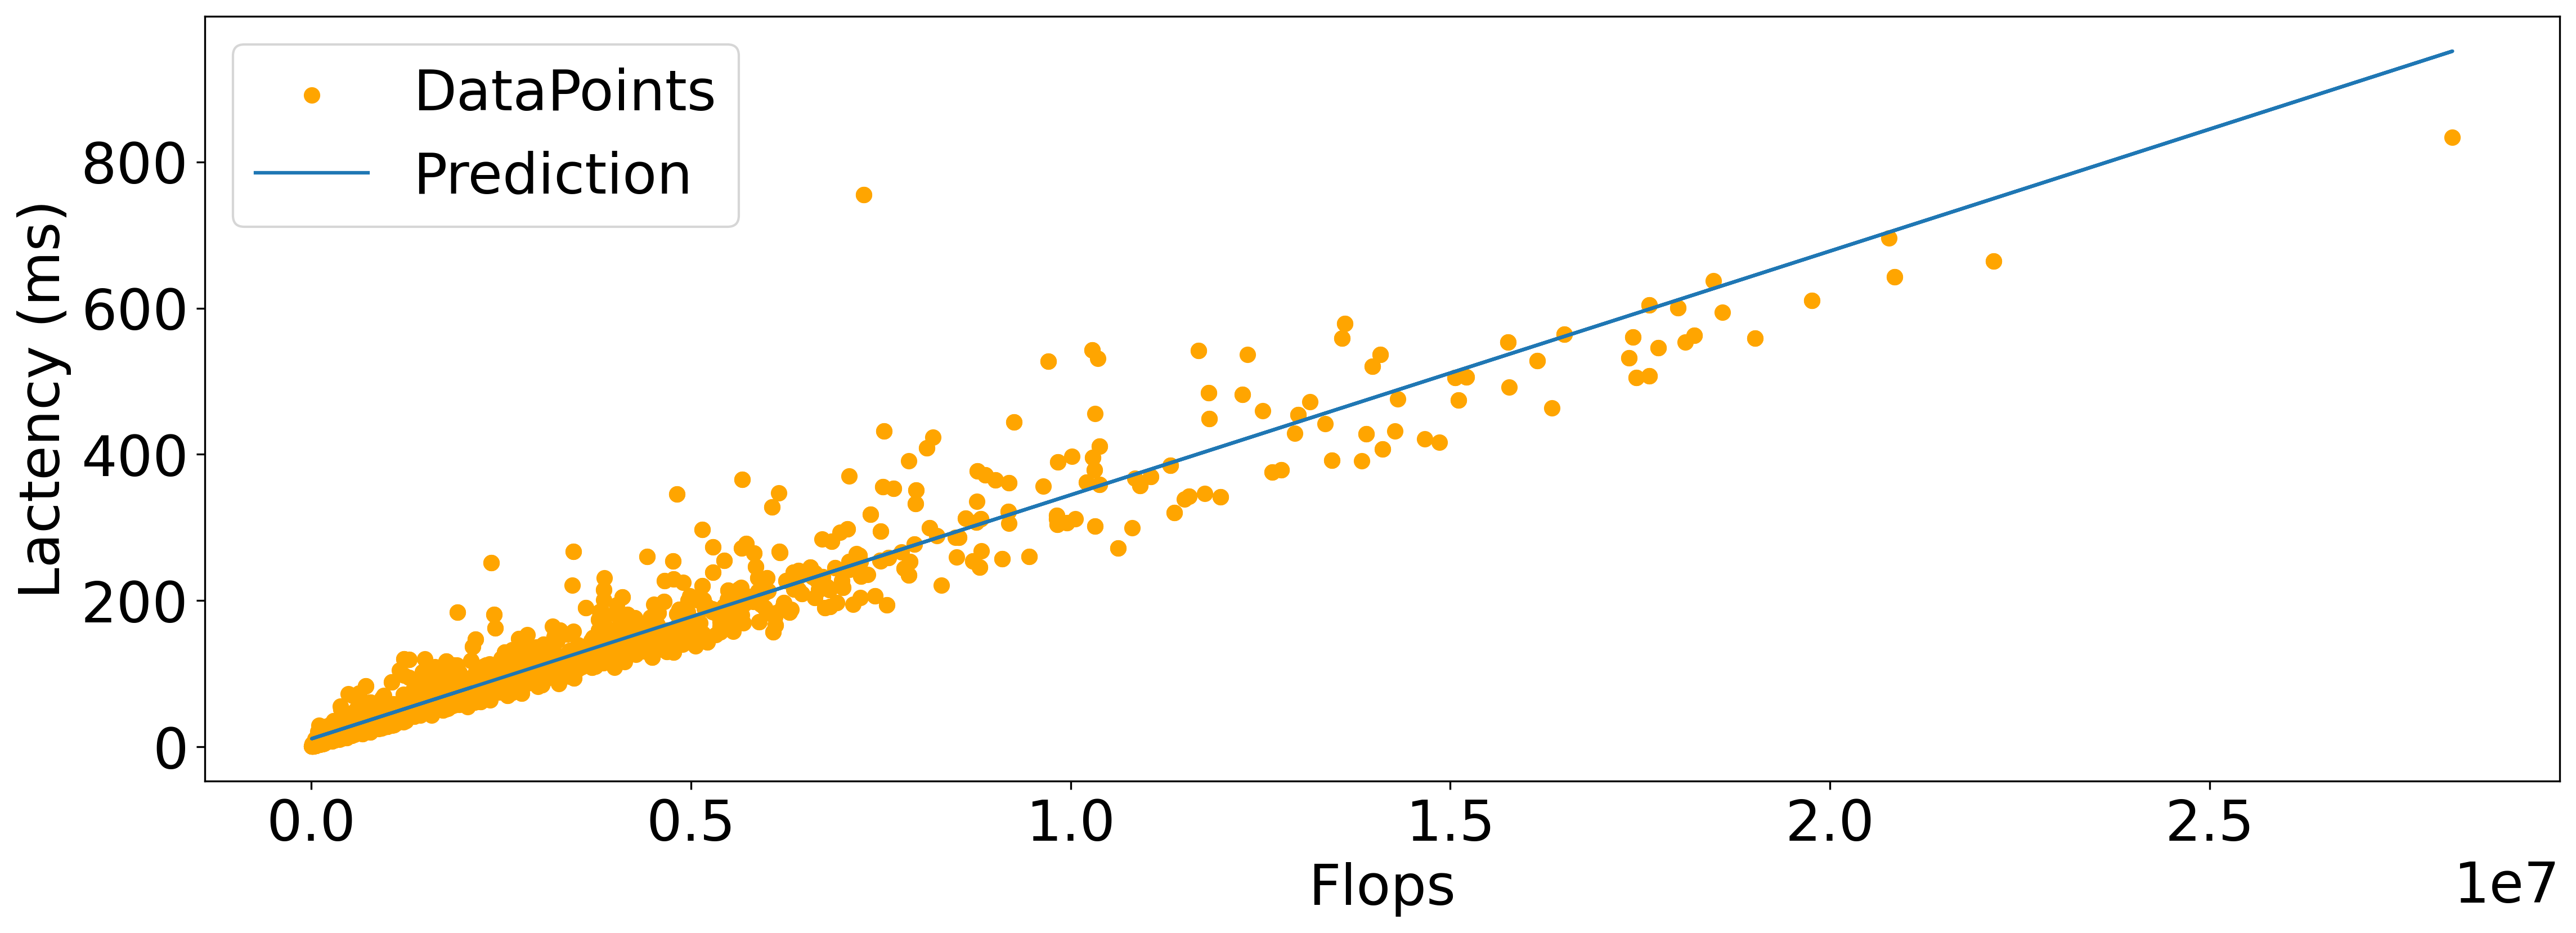

In [92]:
from matplotlib import figure as fig
from sklearn.linear_model import LinearRegression

flops = np.asarray(jp.flops)
modelTimings = [x.wholeModel.millis for x in jp.timings]
print(len(modelTimings))


timings_gpr = np.expand_dims(modelTimings, 1)
flops_gpr = np.expand_dims(flops, 1)

lgr = LinearRegression()
lgr.fit(flops_gpr, modelTimings)
print("R^2 - Score: ", lgr.score(flops_gpr, modelTimings))
print("LGR_Latency_Coeffs: ", lgr.coef_)

figure(figsize=(18, 6), dpi=300)
plt.scatter(flops, modelTimings, color="orange", label="DataPoints")
plt.plot(flops, lgr.predict(flops_gpr), label="Prediction")
plt.ylabel("Lactency (ms)")
plt.xlabel("Flops")
plt.legend()
plt.savefig(LATEX_IMAGES + 'flops_lat_whole_model.pdf', dpi=400, bbox_inches='tight')

## Conv2D

R^2 - Score:  0.9364901359611647
LGR_Latency_Coeffs:  [[2.8927005e-05]]


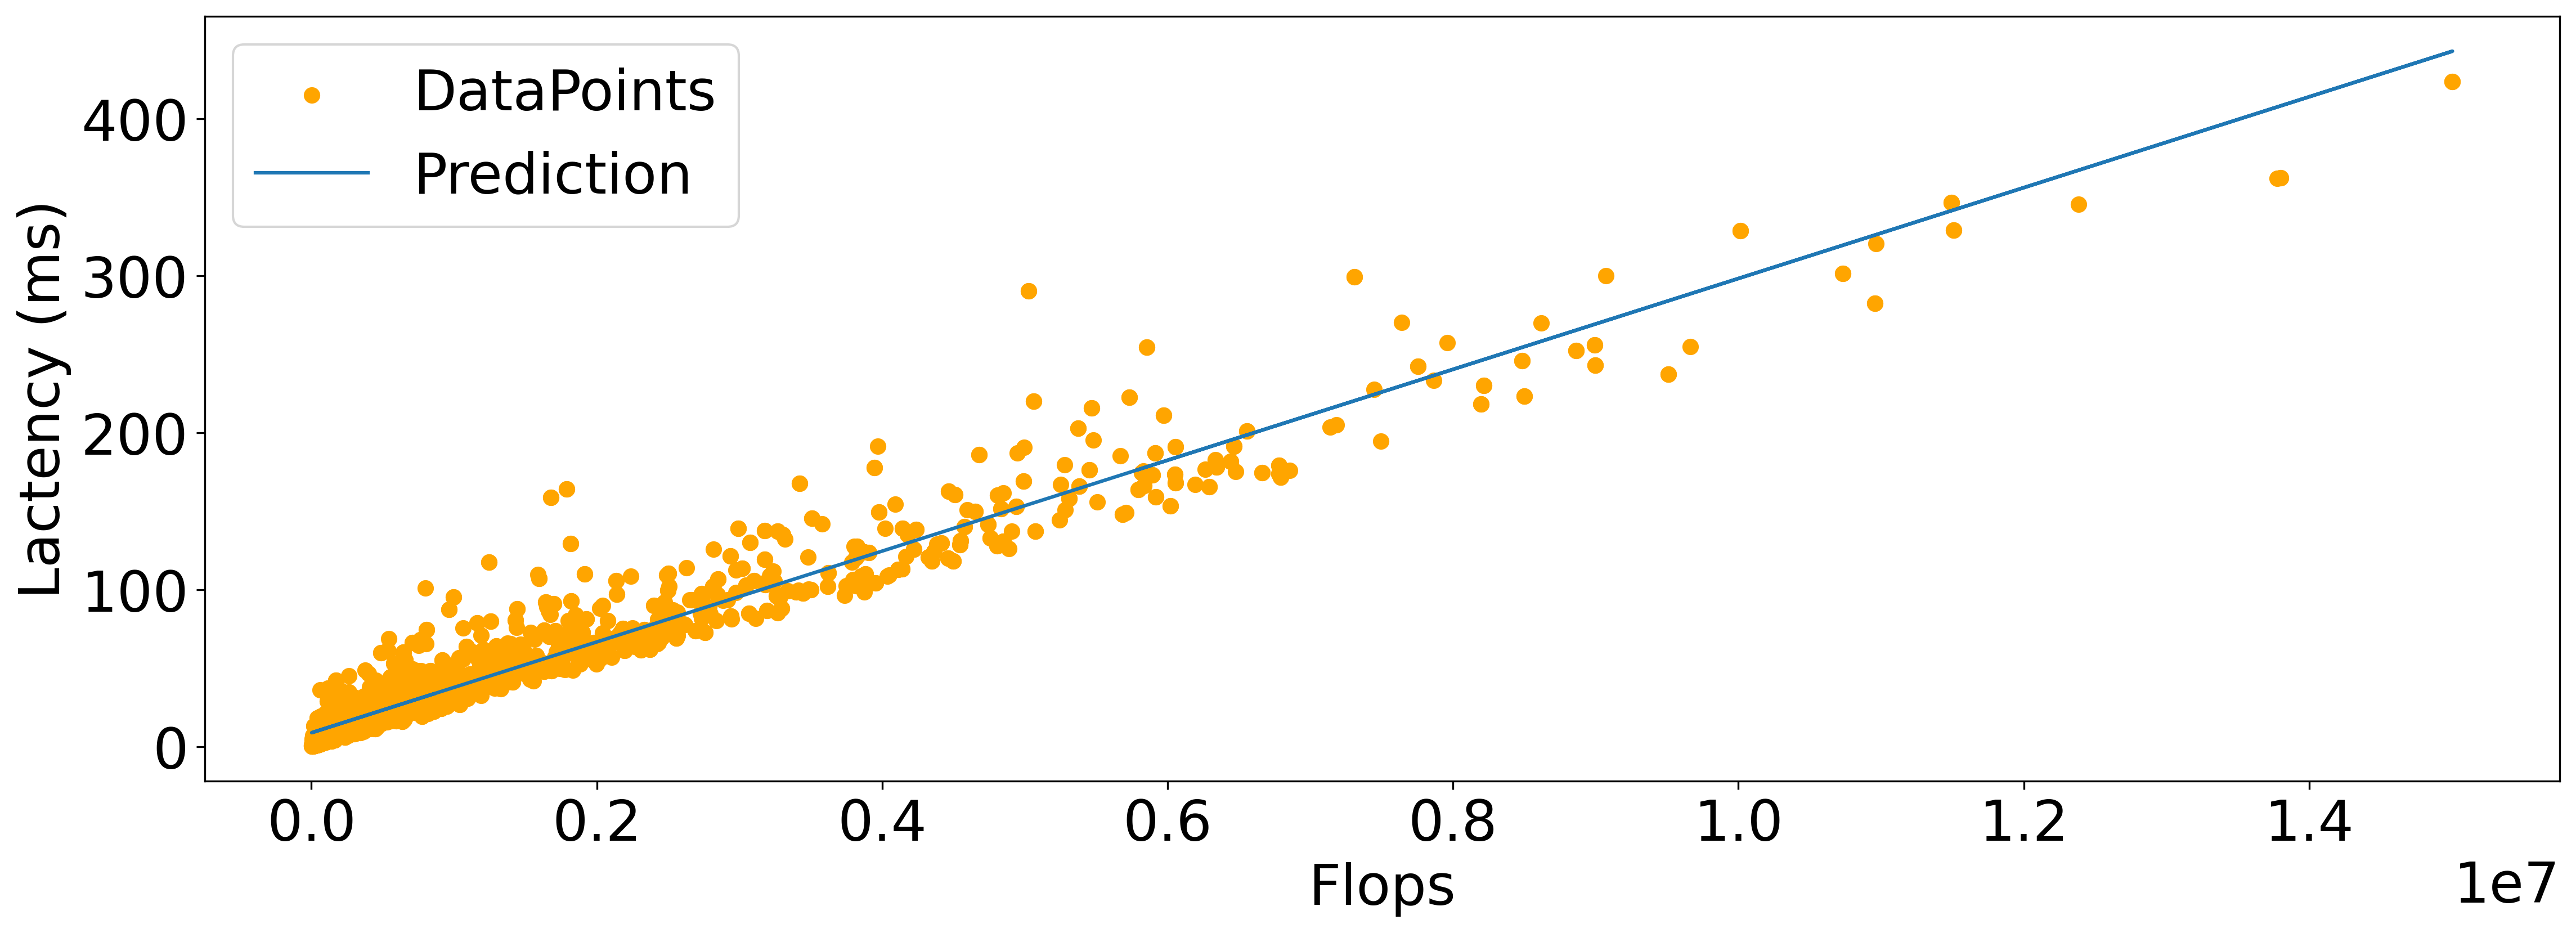

In [93]:
# 3: Conv2D
conv_timings = [x.layer(3) for x in jp.timings]

# conv_timings = [x for x in conv_timings if x[0]["output"][2] in [1,2,3,4] and x[0]["input"][2] in [1,2,3,4]]

config, millis = list(zip(*conv_timings))
millis = [x["millis"] for x in millis]


flps = [calcFlops("Conv2D", x) for x in config]

flps = np.asarray(flps)
mls = np.asarray(millis)


mls_reg = np.expand_dims(mls, 1)
flps_reg = np.expand_dims(flps, 1)


lgr_conv = LinearRegression()
lgr_conv.fit(flps_reg, mls_reg)


print("R^2 - Score: ", lgr_conv.score(flps_reg, mls))
print("LGR_Latency_Coeffs: ", lgr_conv.coef_)

figure(figsize=(18, 6), dpi=300)
plt.scatter(flps, mls, color="orange", label="DataPoints")
plt.plot(flps, lgr_conv.predict(flps_reg), label="Prediction")
plt.ylabel("Lactency (ms)")
plt.xlabel("Flops")
plt.legend()

plt.savefig(LATEX_IMAGES + 'flops_lat_conv2D.pdf', dpi=400, bbox_inches='tight')

## Dense

2401
{'activation': 'relu', 'id': 2, 'input': 672, 'name': 'Dense', 'output': 18}
R^2 - Score:  0.9973673497449419
LGR_Latency_Coeffs:  [[3.01548611e-05]]


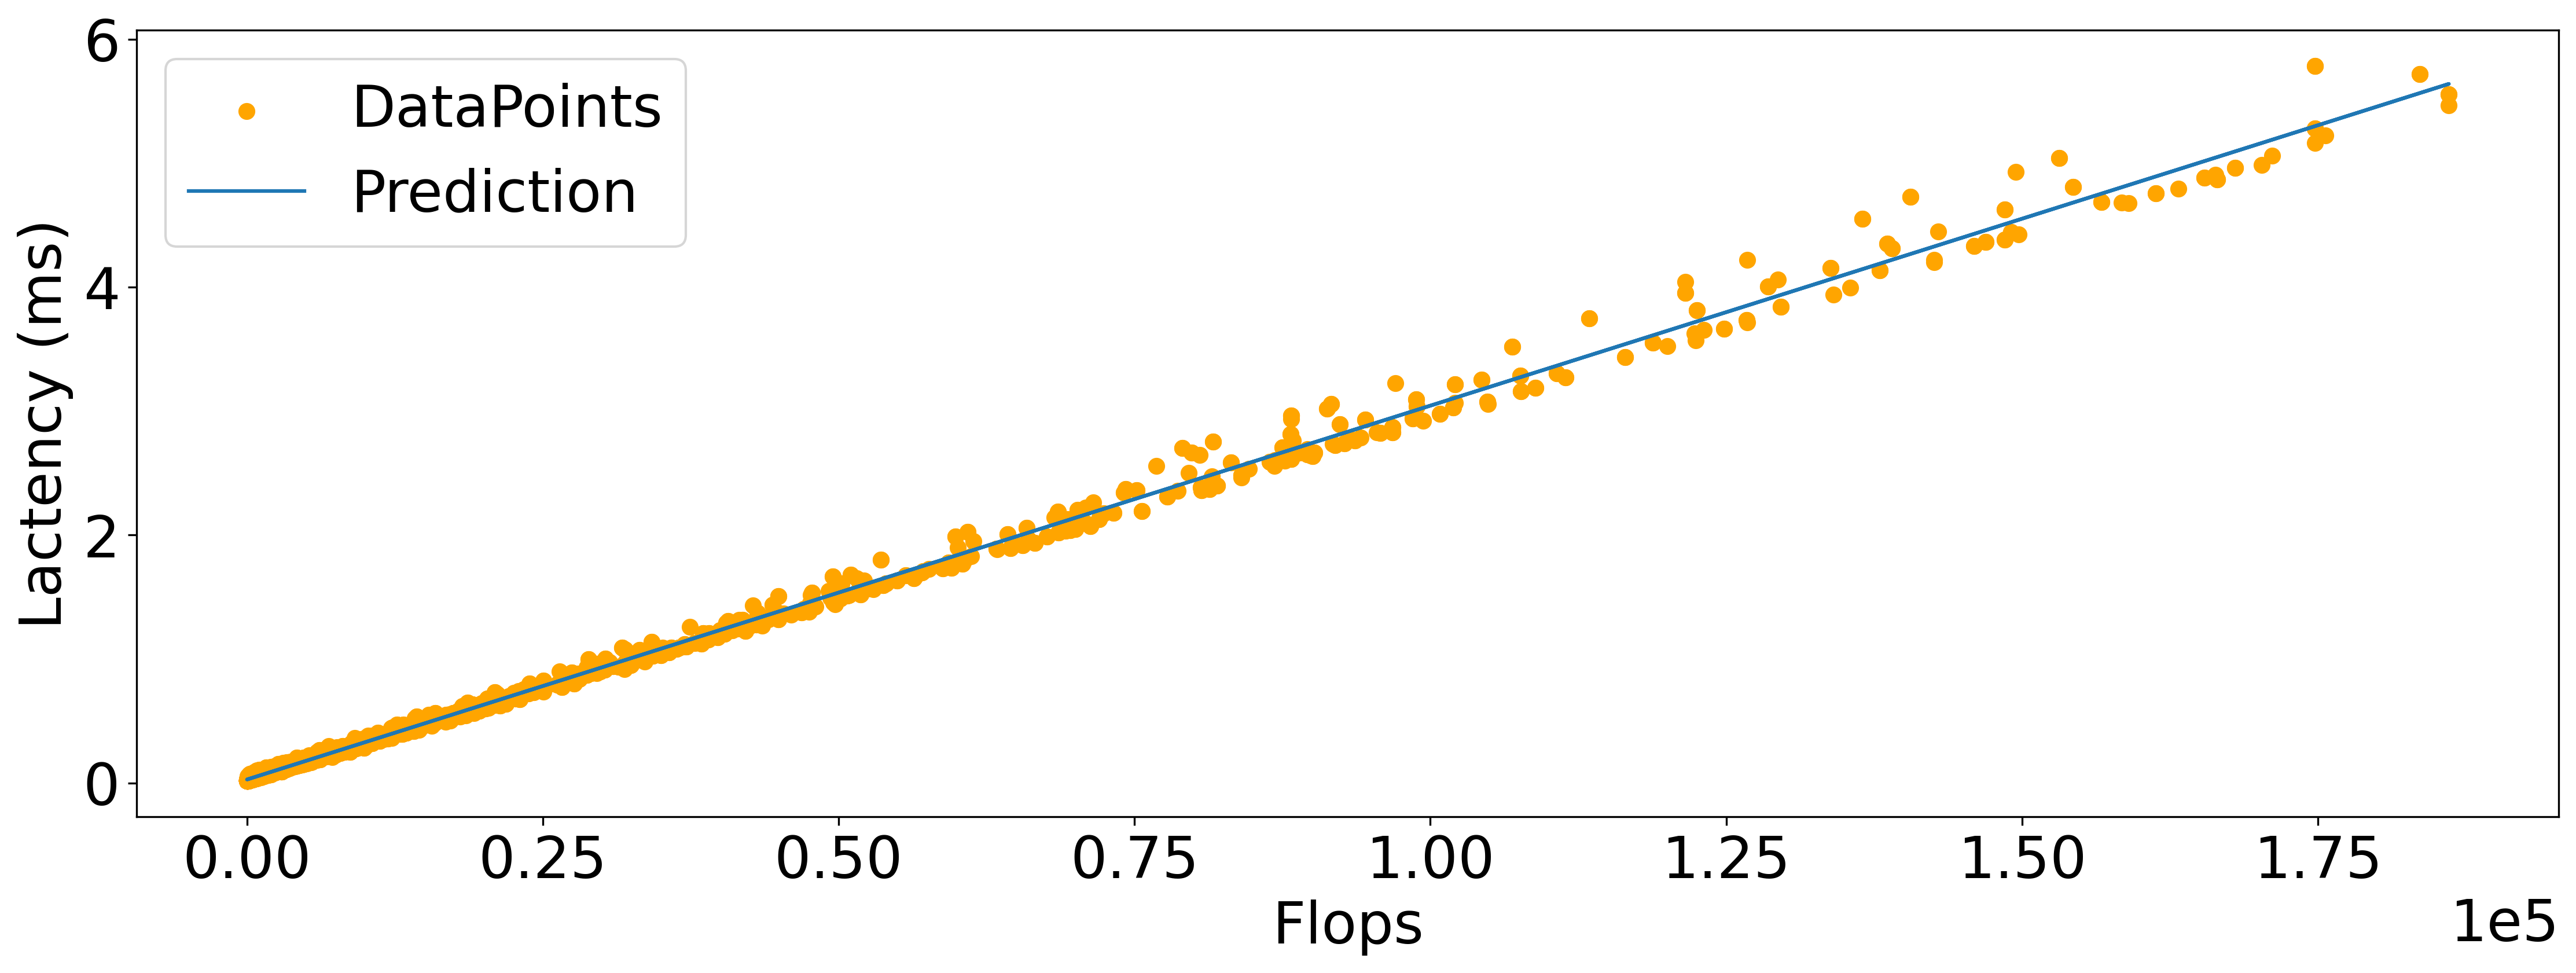

In [94]:
# 9: Dense
conv_timings = [x.layer(9) for x in jp.timings]
config, millis = list(zip(*conv_timings))
millis = [x["millis"] for x in millis]

print(len(millis))

print(config[0])

flps = [calcFlops("Dense", x) for x in config]

flps = np.asarray(flps)
mls = np.asarray(millis)


mls_reg = np.expand_dims(mls, 1)
flps_reg = np.expand_dims(flps, 1)


lgr_conv = LinearRegression()
lgr_conv.fit(flps_reg, mls_reg)


print("R^2 - Score: ", lgr_conv.score(flps_reg, mls))
print("LGR_Latency_Coeffs: ", lgr_conv.coef_)


figure(figsize=(18, 6), dpi=300)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.scatter(flps, mls, color="orange", label="DataPoints")
plt.plot(flps, lgr_conv.predict(flps_reg), label="Prediction")
plt.ylabel("Lactency (ms)")
plt.xlabel("Flops")
plt.legend()
plt.savefig(LATEX_IMAGES + 'flops_lat_dense.pdf', dpi=400, bbox_inches='tight')

## Softmax

In [95]:
# 9: Dense
conv_timings = [x.layer(25) for x in jp.timings]
config, millis = list(zip(*conv_timings))
millis = [x["millis"] for x in millis]

print(len(millis))

print(config[0])

flps = [calcFlops("Dense", x) for x in config]

flps = np.asarray(flps)
mls = np.asarray(millis)


mls_reg = np.expand_dims(mls, 1)
flps_reg = np.expand_dims(flps, 1)


lgr_conv = LinearRegression()
lgr_conv.fit(flps_reg, mls_reg)


print("R^2 - Score: ", lgr_conv.score(flps_reg, mls))
print("LGR_Latency_Coeffs: ", lgr_conv.coef_)

figure(figsize=(18, 6), dpi=300)
plt.scatter(flps, mls, color="orange", label="DataPoints")
plt.plot(flps, lgr_conv.predict(flps_reg), label="Prediction", style="sci")
plt.ylabel("Lactency (ms)")
plt.xlabel("FLops")
plt.title("Flops vs. Latency (ms)")
plt.legend()
plt.savefig(LATEX_IMAGES + 'flops_lat_dense.pdf')

KeyError: 25

## Memory


R^2 - Score:  0.9869307139118199
LGR_Memory_Coeffs:  [1.0095299]


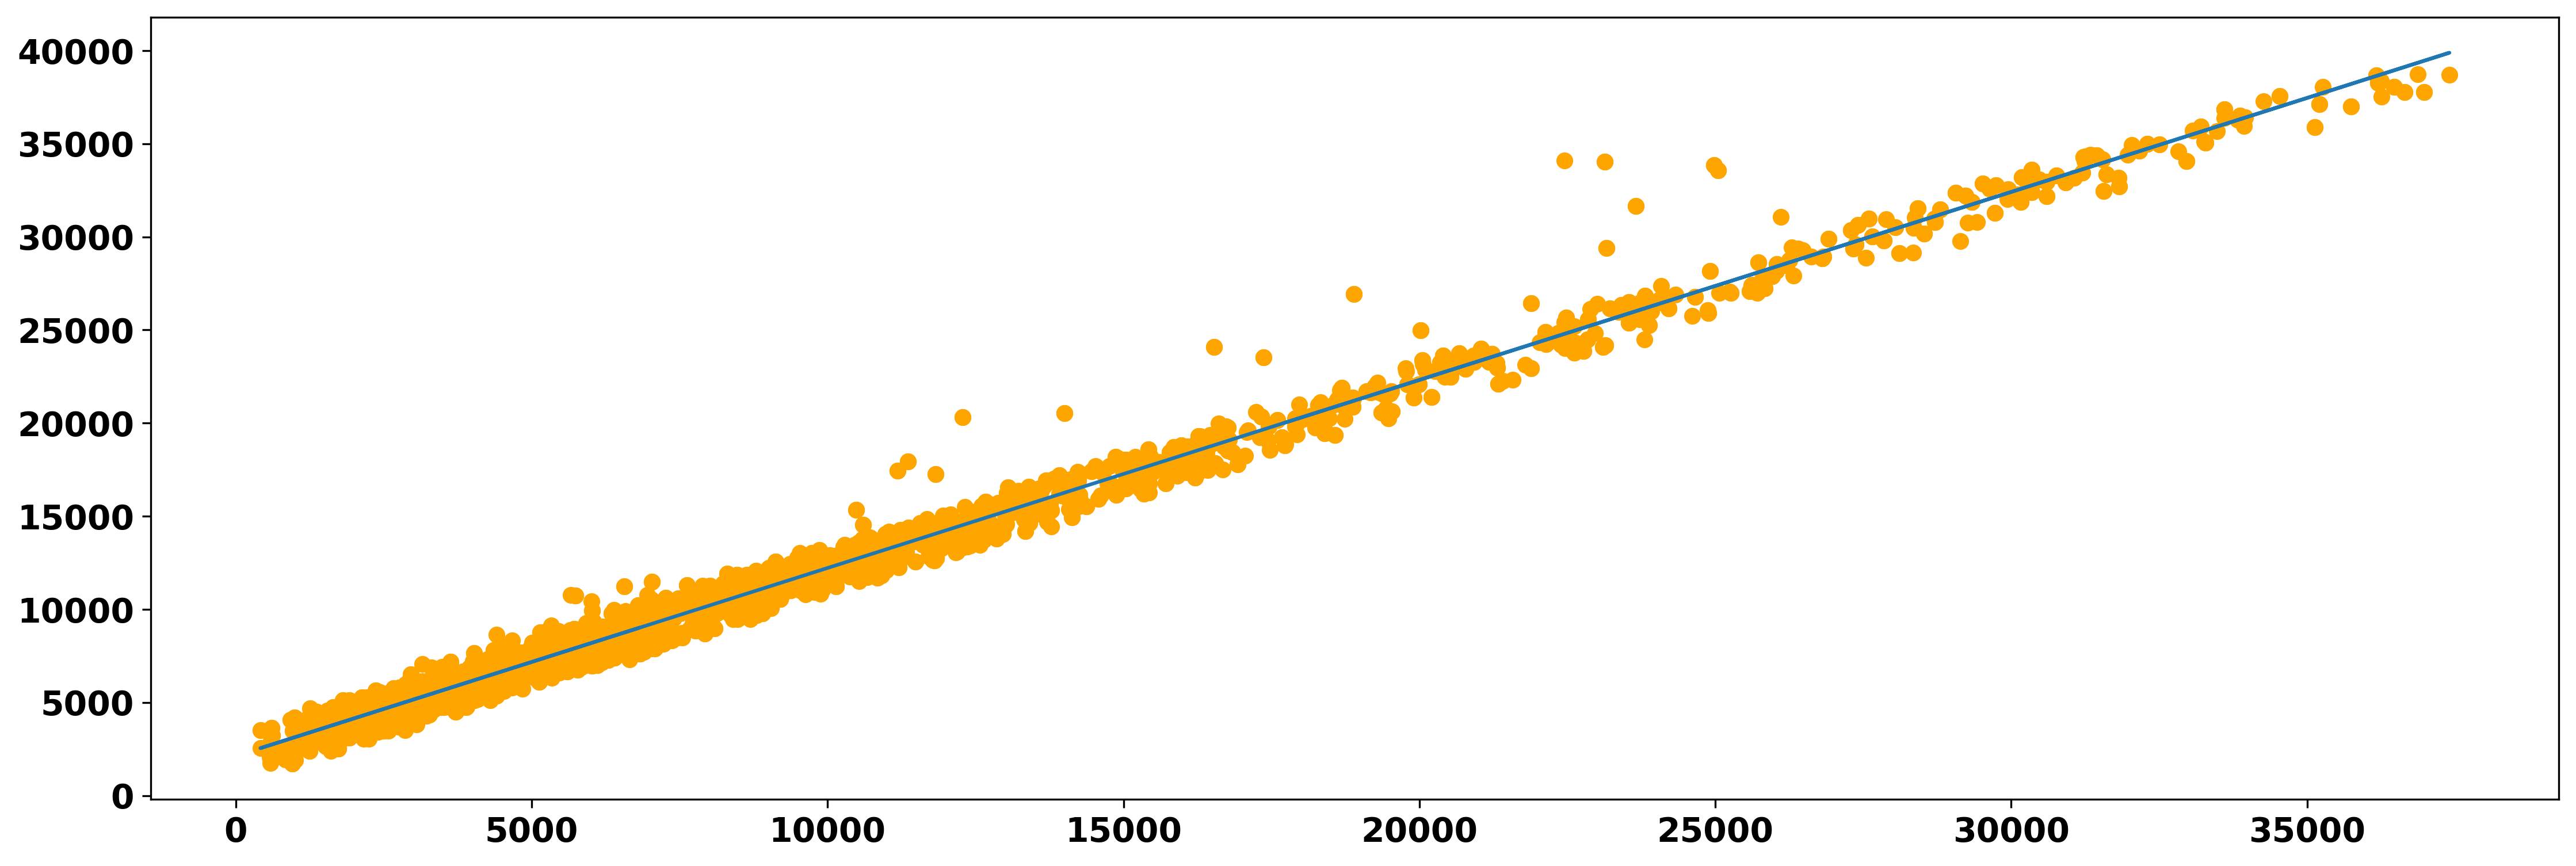

In [ ]:
tensorArea = [int(x) for x in jp.tensorAreaUsed]

def calcMemory(type, input_shape, output_shape, kernel_shape=None):
    if type.lower() == "dense":
        return np.prod(input_shape) + np.prod(output_shape)
    if isinstance(input_shape[0], list):
        in_size = np.sum([np.prod(i) for i in input_shape])
    else:
        in_size = np.prod(input_shape)
    out_size = np.prod(output_shape)

    mem = 0
    if type.lower() == "conv2d":
        mem += 4 * np.prod(kernel_shape[0:2]) * input_shape[-1]

    # print("type: ", type, "input_shape: ", input_shape, "output_shape: ",
    #       output_shape, "arm: ", mem, "kernel_size: ", kernel_shape, "in_s: ", in_size, "out_s: ", out_size, "mem: ", mem + in_size + out_size)
    return mem + in_size + out_size

memoryEstPeak = []
for i in range(jp.numRecords):
    data, filepath = jp.getRecord(i)
    config = data["modelConfig"]
    mem = 0
    for cfg in config:
        type = cfg["name"]
        input_shape = cfg["input"]
        output_shape = cfg["output"]
        kernel_shape = cfg["filter"] if type.lower() == "conv2d" else None
        mem = max(calcMemory(type, input_shape, output_shape, kernel_shape), mem)
    memoryEstPeak.append(mem)
    


memoryEstPeak_lgr = np.expand_dims(memoryEstPeak, 1)

figure(figsize=(18, 6), dpi=300)
lgrMemory = LinearRegression()
lgrMemory.fit(memoryEstPeak_lgr, tensorArea)
print("R^2 - Score: ", lgrMemory.score(memoryEstPeak_lgr, tensorArea))
print("LGR_Memory_Coeffs: ", lgrMemory.coef_)

plt.scatter(memoryEstPeak, tensorArea, color="orange")
plt.plot(memoryEstPeak, lgrMemory.predict(memoryEstPeak_lgr))